### Analysis about the current US fuel cycle
Includes each of the current reactors and their decommissioning, based on license expirations. This notebook looks specifically at the amount of fuel and enriched U that is required by the current fuel cycle.

In [1]:
! rm ../outputs/united_states_2020.sqlite
! cyclus -i ../inputs/united_states_2020.xml -o ../outputs/united_states_2020.sqlite

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

Experimental Warning: MatlBuyPolicy is experimental and its API may be subject to change
Experimental Warning: MatlSellPolicy is experimental and its API may be subject to change
Experimental Warning: The Storage Facility is experimental.
Experimental Warning: MatlBuyPolicy is experimental and its API may be subject to change
Experimental Warning: MatlSellPolicy is experimental and its API may be subject to change
Experimental Warning: The Storage Facility is experimental.
Experimental Warning: MatlBuyPolicy is experimental and its API may be subject to change
Experimental Warning: MatlSellPolicy is experimental and its API may be subject to change
Experimental Warning: The Storage Facility is experimental.
Experimental Warning: MatlBuyPolicy is experimental and its API may be subject to change
Experimental Warning: MatlSellPolicy is experimental and its API may be subject to change
Experimental Warning: The Storage Facility is experimental.
Experimental Warning: MatlBuyPolicy is exper

In [15]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from functools import reduce

In [14]:
import cymetric as cym
from cymetric import timeseries
from cymetric import filters
from cymetric import tools

import transition_metrics as tm

In [17]:
current_outfile = '../outputs/united_states_2020.sqlite'
mmr_outfile = '../outputs/united_states_mmr.sqlite'
xe100_outfile = '../outputs/united_states_xe100.sqlite'

In [22]:
current_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill',
                 'Enrichment', 'FuelFab', 'DryStorage',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']

## Reactors Built and Decommissioned

This section plots the number of each reactor type in the simulation as a function of time

In [23]:
current_reactors = tm.rx_commission_decommission(current_outfile, current_nonlwr)
current_reactors = tm.add_year(current_reactors)

/home/amandabachmann/transition-scenarios/input/haleu/analysis/transition_metrics.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'][index] = np.round(df['Time'][index] / 12 + 1965, 2)


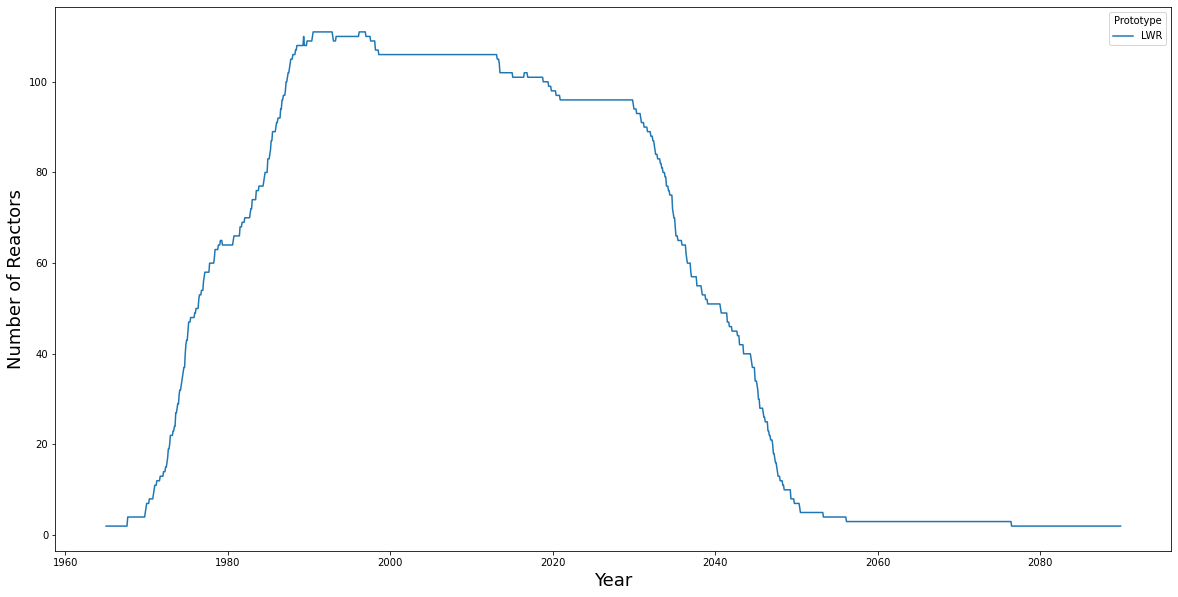

In [25]:
tm.plot_metric(current_reactors, ['Year','lwr_total'], ['Year','Number of Reactors','Prototype', 'LWR'])
#plt.savefig('figures/rx_deployment_2020.png')

# Calculating annual throughputs

## Calculating annual enriched U supplied by enrichment facility (product)

In [265]:
enriched_u = tm.calculate_throughput('../outputs/united_states_2020.sqlite', 'enr_u')

/home/amandabachmann/anaconda3/envs/cyclus-env/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


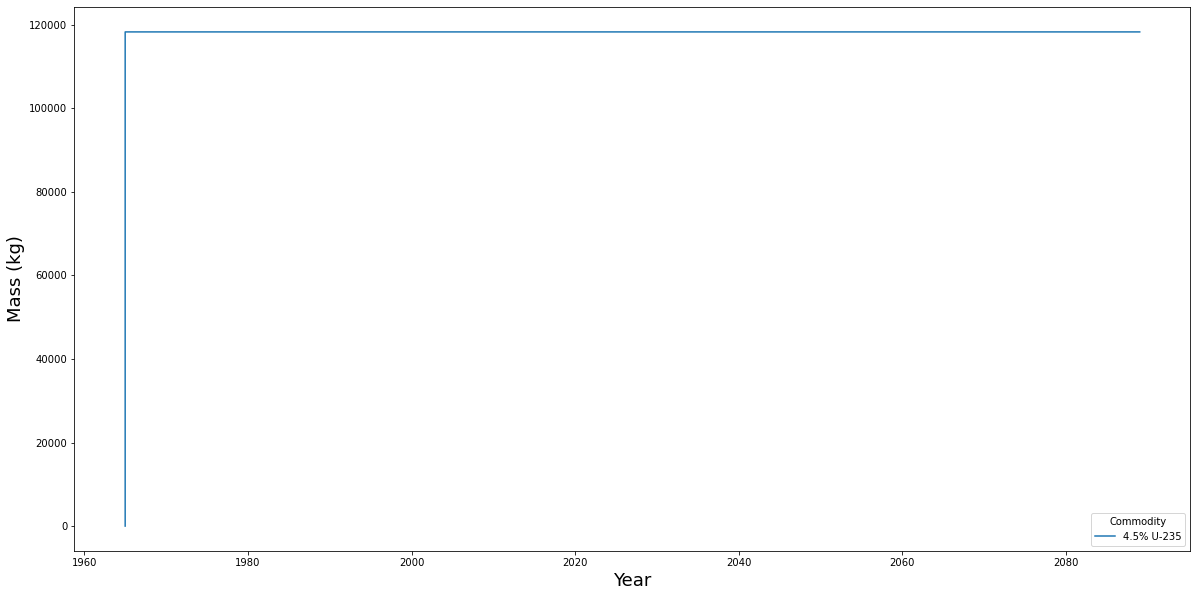

In [267]:
tm.plot_metric(enriched_u, ['Year', 'enr_u'], ['Year', 'Mass (kg)','Commodity', '4.5% U-235'])

## Calculating annual feed material

In [268]:
uf6 = tm.calculate_throughput('../outputs/united_states_2020.sqlite', 'uf6')

/home/amandabachmann/anaconda3/envs/cyclus-env/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


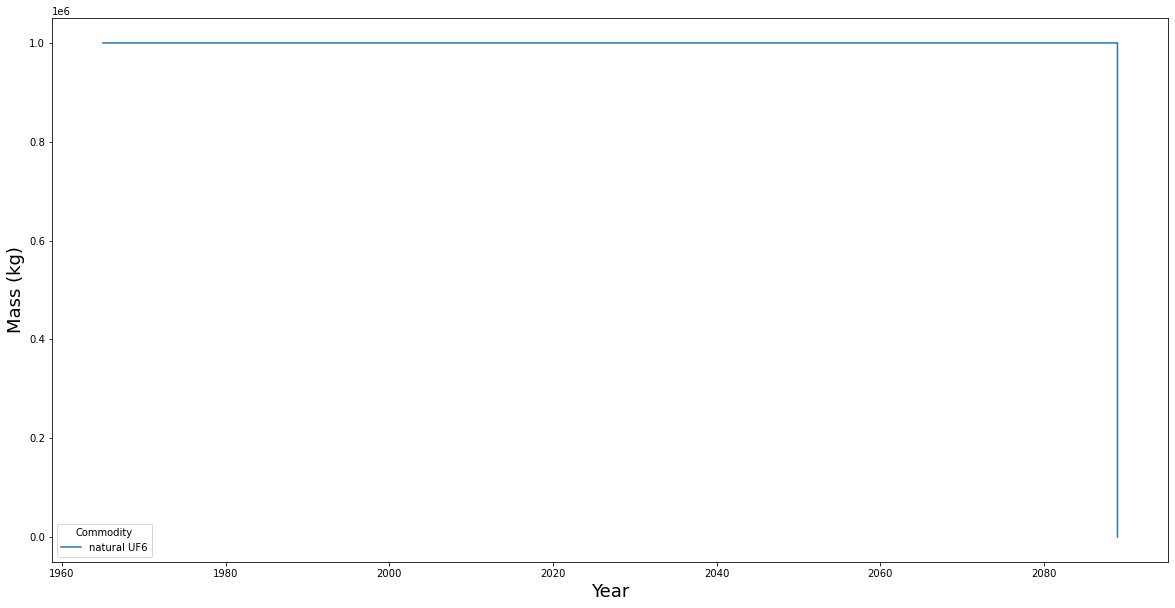

In [269]:
tm.plot_metric(uf6, ['Year', 'uf6'], ['Year', 'Mass (kg)','Commodity', 'natural UF6'])

## Calculating annual tails production

In [270]:
tails = tm.calculate_throughput('../outputs/united_states_2020.sqlite', 'tails')

/home/amandabachmann/anaconda3/envs/cyclus-env/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


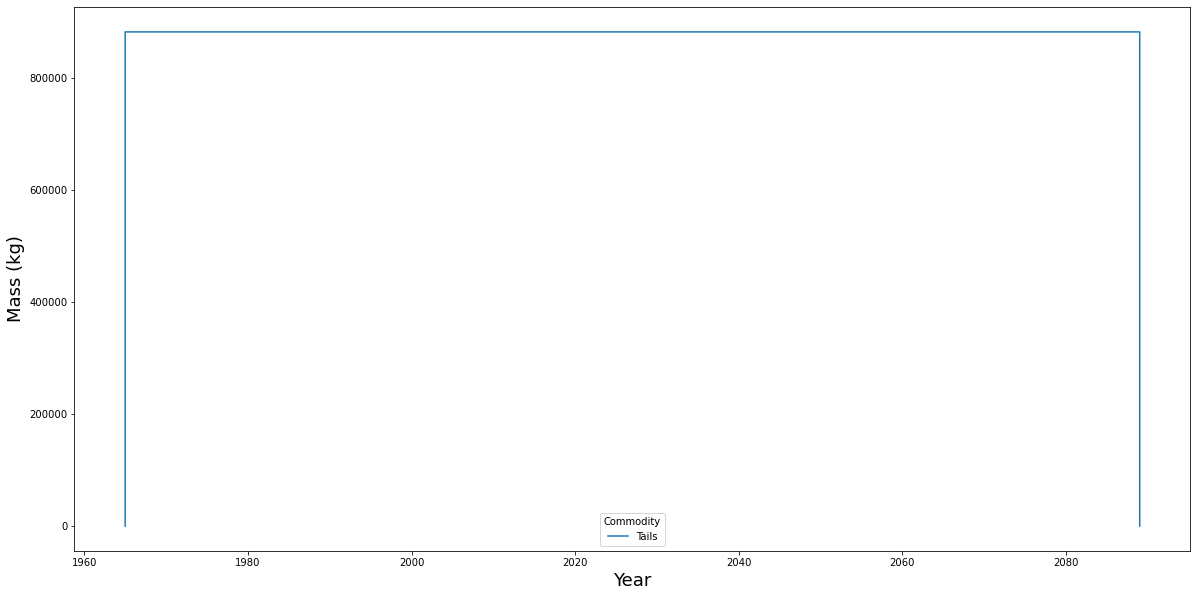

In [271]:
tm.plot_metric(tails, ['Year', 'tails'], ['Year', 'Mass (kg)','Commodity', 'Tails'])

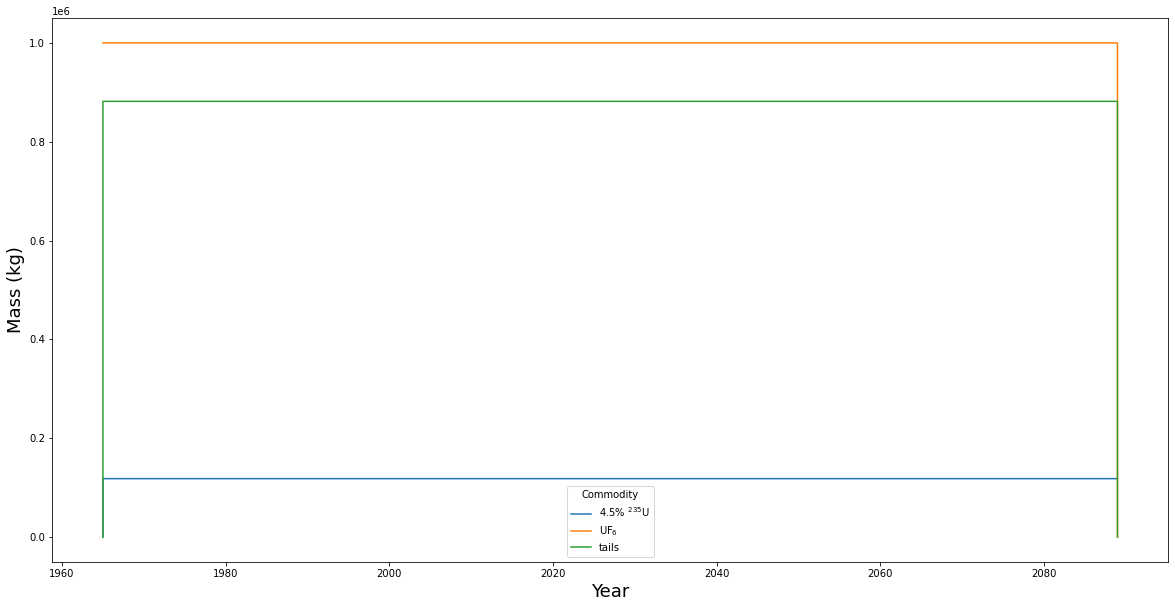

In [303]:
current_us_commodities = tm.merge_databases([enriched_u, uf6, tails])
tm.plot_metric(current_us_commodities, ['Year', 'enr_u', 'uf6', 'tails'], 
            ['Year', 'Mass (kg)', 'Commodity', r'4.5% $^{235}$U', r'UF$_6$','tails'])

## Determining feed, tails, and product assay

In [133]:
#Defining assays
x_p = 0.045
x_f = 0.00711
x_t = 0.002

## SWU Calculation
SWU = (P*V(x_p) + T*V(x_t) - F*V(x_f))*t

V(x_i) = (2*x_i-1)*ln(x_i/(1-x_i))

In [210]:
tm.calculate_SWU(100, x_p, 742.94, x_t, 842.94, x_f)

4870.271760515327

/home/amandabachmann/anaconda3/envs/cyclus-env/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


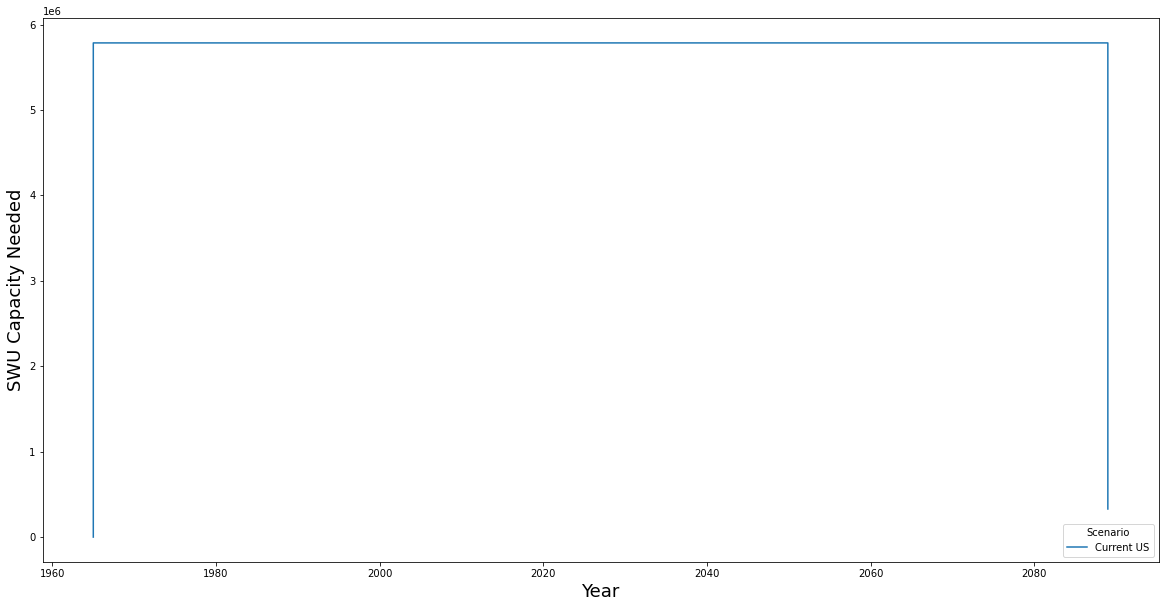

In [236]:
SWU = tm.calculate_SWU(enriched_u['enr_u'], x_p, tails['tails'], x_t, uf6['uf6'], x_f)
Annual_SWU = SWU.to_frame().reset_index()
Annual_SWU = tm.add_year(Annual_SWU)
#Annual_SWU.columns
Annual_SWU = Annual_SWU.rename(columns={0:'SWU'})
tm.plot_metric(Annual_SWU, ['Year', 'SWU'], ['Year', 'SWU Capacity Needed', 'Scenario', 'Current US'])

## Calculate eletricity output

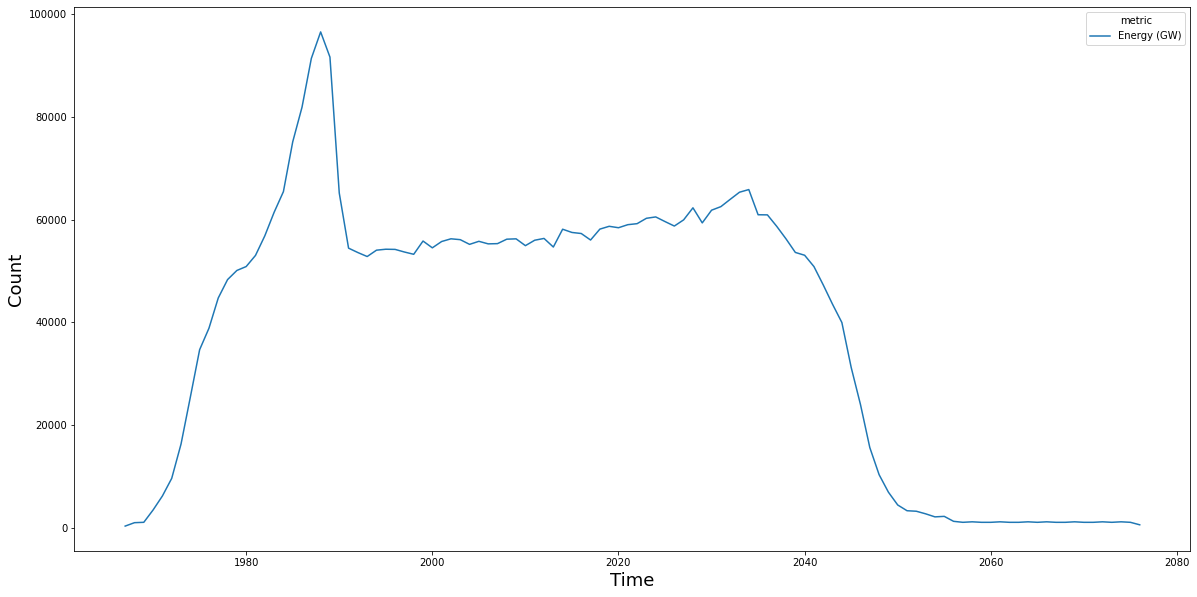

In [29]:
tm.plot_metric(energy_output, ['Year', 'Energy (GW)'])

In [30]:
max(energy_output['Energy (GW)'])

96535.58333333334